# Final Project - Classification of Honey Bee and Bumble Bee

In this project we are implementing a deep learning model that automatically detects honey bess and bumble bees. Once the model is trained, we evaluate it on the test data to see how good the model can perform the defined task.

<em>A honey bee.</em></p>
<p><img src="https://assets.datacamp.com/production/project_555/img/92_notebook.jpg" alt="honey bee">

<em>A bumble bee .</em></p>

<p><img src="https://assets.datacamp.com/production/project_555/img/20_notebook.jpg" alt="bumble bee">


## Mounting the drive

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Import the necessary libraries

In [ ]:
import pickle
from pathlib import Path
from skimage import io

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# import keras library
import keras

# import Sequential from the keras models module
from keras.models import Sequential

# import Dense, Dropout, Flatten, Conv2D, MaxPooling2D from the keras layers module
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

Using TensorFlow backend.


## 2. Load image labels
Now lets look at the labels for our data. We will load our <code>labels.csv</code> file into a DataFrame called <code>labels</code>, where the index column is the image name and the <code>genus</code> column tells us the bee type. <code>genus</code> takes the value of either <code>0.0</code> (honey bee) or <code>1.0</code> (bumble bee).

In [ ]:
# load labels.csv from datasets folder using pandas
labels = pd.read_csv('/content/drive/MyDrive/Naive-Bees-Deep-Learning-with-Images/datasets/labels.csv', index_col=0)

# print value counts for genus
print(labels.genus.count())
DEADLINE: 16.02.2020

# assign the genus label values to y
y = labels.genus.values

3968


Let's look at the data for a sample image. 

/content/drive/MyDrive/Naive-Bees-Deep-Learning-with-Images
Example image has shape:  (200, 200, 3)
RGB values for the top left pixel are: [129 109 102]


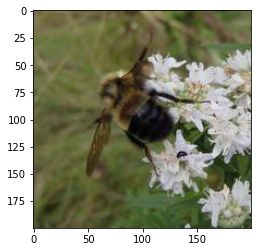

In [ ]:
# load an image and explore
%cd /content/drive/MyDrive/Naive-Bees-Deep-Learning-with-Images/
example_image = io.imread('datasets/images/{}.jpg'.format(labels.index[0]))

# show image
plt.imshow(example_image)

# print shape
print('Example image has shape: ', example_image.shape)
                    
# print color channel values for top left pixel
print('RGB values for the top left pixel are:', example_image[0,0,:])

## 4. Normalize image data
Now we need to normalize the image data. Normalization is a general term that means changing the scale of our data so it is consistent.</p>
<p>In this case, we want each feature to have a similar range so our neural network can learn effectively across all the features.
<p>We will scale our data so that it has a mean of 0 and standard deviation of 1. We'll use sklearn's <code>StandardScaler</code> to do this, which entails taking each value, subtracting the mean, and then dividing by the standard deviation. We need to do this for each color channel (i.e. each feature) individually.

In [ ]:
%cd /content/drive/MyDrive/Naive-Bees-Deep-Learning-with-Images/
# initialize standard scaler
ss = StandardScaler()
count = 0
image_list = []
for i in labels.index:
    # load image
    img = io.imread('datasets/images/{}.jpg'.format(i)).astype(np.float64)
    
    # for each channel, apply standard scaler's fit_transform method
    for channel in range(img.shape[2]):
        img[:, :, channel] = ss.fit_transform(img[:, :, channel])
        # if(img.shape != (200, 200, 3)):
        #   count = count+1
        #   print("datasets/images/{}.jpg".format(i) + ": " +str(img.shape))

    # append to list of all images
    image_list.append(img)

# print(count)
# convert image list to single array
X = np.array(image_list)

# print shape of X
print(X.shape)

/content/drive/MyDrive/Naive-Bees-Deep-Learning-with-Images
(3968, 200, 200, 3)


## 5. Split into train, test, and evaluation sets
Now we split the data into train, test, and evaluation sets. To do this, we'll first allocate 20% of the data into our evaluation, or holdout, set. This is data that the model never sees during training and will be used to score our trained model.</p>
<p>We will then split the remaining data, 60/40. We will pass both the train and test sets into the neural network. </p>

In [ ]:
# split out evaluation sets (x_eval and y_eval)
x_interim, x_eval, y_interim, y_eval = train_test_split(X,
                                           y,
                                           test_size=0.2,
                                           random_state=52)

# split remaining data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_interim,
                                           y_interim,
                                           test_size=0.4,
                                           random_state=52)

# examine number of samples in train, test, and validation sets
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_eval.shape[0], 'eval samples')

x_train shape: (1904, 200, 200, 3)
1904 train samples
1270 test samples
794 eval samples


This is the number of images which we have in our dataset.


## 6. Model building
<p>Now we build the deep learning model, a convolutional neural network (CNN). </p>
<p>Building a CNN begins with specifying the model type. In our case, we'll use a Sequential model, which is a linear stack of layers. We'll then add two convolutional layers. Then we add a Max Pooling layer, Conv2D, Droupout to avoid overfitting with 25% drop, Flatten, Dense, and another dropout layer to safeguard against overfitting, this time with a rate of 50% drop. And now a final Dense layer which calculates the probability the image is either a bumble bee or honey bee.


In [ ]:
# set model constants
num_classes = 1

# define model as Sequential
model = Sequential()

# first convolutional layer with 32 filters
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(200, 200, 3)))

# add a second 2D convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(200, 200, 3)))

In [ ]:
# reduce dimensionality through max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
# third convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# add dropout to prevent over fitting
model.add(Dropout(0.25))
# necessary flatten step preceeding dense layer
model.add(Flatten())
# fully connected layer
model.add(Dense(128, activation='relu'))

# add additional dropout to prevent overfitting
model.add(Dropout(0.5))

# prediction layers
model.add(Dense(num_classes, activation='sigmoid', name='preds'))

# show model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 196, 196, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 98, 98, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 96, 96, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 589824)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               7

## 8. Compile and train model
<p>As the model architecture is defined, now we compile the model for training. For this we need to specify the loss function (what we're trying to minimize), the optimizer (how we want to go about minimizing the loss), and the metric (how we'll judge the performance of the model).</p>
<p>Then, we'll call <code>.fit</code></a> to begin the trainig the process. </p>

We are using checkpoints to save the best weights by checking the validation loss. We use earlystopping here to avoid overfitting of the model.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model.compile(
    # set the loss as binary_crossentropy
    loss=keras.losses.binary_crossentropy,
    # set the optimizer as stochastic gradient descent
    optimizer=keras.optimizers.SGD(lr=0.001),
    # set the metric as accuracy
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint("/content/drive/MyDrive/Naive-Bees-Deep-Learning-with-Images/datasets/checkpoint_notebook/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5", monitor="val_loss", mode="min", save_best_only = True, verbose=1)
earlystop = EarlyStopping(monitor = 'val_loss',  min_delta = 0,  patience = 5, verbose = 1, restore_best_weights = True)
callbacks = [checkpoint,earlystop]

history= model.fit(
    x_train,
    y_train,
    epochs=200,
    verbose=1,
    validation_data=(x_test, y_test),
    callbacks=callbacks
)

Epoch 1/200
60/60 [==============================] - 7s 80ms/step - loss: 0.5554 - accuracy: 0.7499 - val_loss: 0.5053 - val_accuracy: 0.7874

Epoch 00001: val_loss improved from inf to 0.50532, saving model to /content/drive/MyDrive/Naive-Bees-Deep-Learning-with-Images/datasets/checkpoint_notebook/weights-improvement-01-0.51.hdf5
Epoch 2/200
60/60 [==============================] - 4s 68ms/step - loss: 0.5041 - accuracy: 0.7858 - val_loss: 0.5049 - val_accuracy: 0.7874

Epoch 00002: val_loss improved from 0.50532 to 0.50486, saving model to /content/drive/MyDrive/Naive-Bees-Deep-Learning-with-Images/datasets/checkpoint_notebook/weights-improvement-02-0.50.hdf5
Epoch 3/200
60/60 [==============================] - 4s 68ms/step - loss: 0.4947 - accuracy: 0.7812 - val_loss: 0.4915 - val_accuracy: 0.7874

Epoch 00003: val_loss improved from 0.50486 to 0.49149, saving model to /content/drive/MyDrive/Naive-Bees-Deep-Learning-with-Images/datasets/checkpoint_notebook/weights-improvement-03-0.4

## 9. Visualize model training history



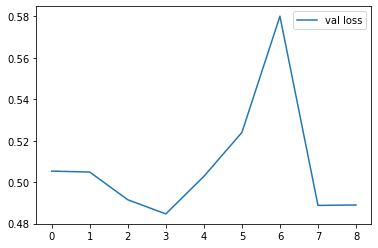

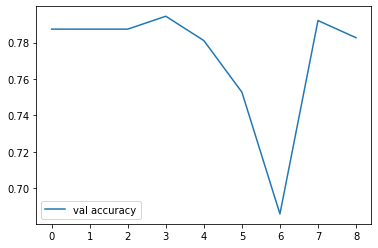

<Figure size 432x288 with 0 Axes>

In [ ]:
# summarize history for loss
# plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('Val_loss')

# plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('Val_accuracy')

## 9. Load saved model and score
<p>Now we'll load the saved and evaluateto see how well the model did at classifying bumble bees and honey bees for the test and validation sets. Given that our classes are balanced, a model that predicts <code>1.0</code> for every image would get an accuracy around <code>0.5</code>.</p>

In [ ]:
# load pre-trained model
pretrained_cnn = keras.models.load_model('/content/drive/MyDrive/Naive-Bees-Deep-Learning-with-Images/datasets/checkpoint_notebook/weights-improvement-04-0.48.hdf5')

# evaluate model on test set
score = pretrained_cnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("")

# evaluate model on holdout set
eval_score = pretrained_cnn.evaluate(x_eval, y_eval, verbose=0)
# print loss score
print('Eval loss:', eval_score[0])
# print accuracy score
print('Eval accuracy:', eval_score[1])

Test loss: 0.4846564829349518
Test accuracy: 0.7944881916046143

Eval loss: 0.4536413848400116
Eval accuracy: 0.8110831379890442


## 10. Generate predictions
<p>Now lets access probabilities and class predictions for individual images using the <code>.predict</code> and <code>.predict_classes</code> methods.</p>
<p>As we now have a deep learning model that can be used to identify honey bees and bumble bees in images, lets test this on our evaluation dataset which the model has never seen during training.

In [ ]:
# predicted probabilities for x_eval
y_proba = pretrained_cnn.predict(x_eval)

print("First five probabilities:")
print(y_proba[:5])
print("")

# predicted classes for x_eval
y_pred = pretrained_cnn.predict_classes(x_eval)

print("First five class predictions:")
print(y_pred[:5])
print("")

First five probabilities:
[[0.81092304]
 [0.911364  ]
 [0.7142421 ]
 [0.8865571 ]
 [0.62124336]]



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


First five class predictions:
[[1]
 [1]
 [1]
 [1]
 [1]]

